### To be able to answer our defining questions, the data needs to be separated into a nintendo and non ninetendo data frame. It will also be useful to handle null values at this stage of the analysis

# Data cleaning:

### Separating dataframes into nintendo and non-nintendo publishers

In [1]:
import pandas as pd

vgsales_df = pd.read_csv('vgsales.csv')

# Assuming df_cleaned should be vgsales_df based on the context provided
nintendo_df = vgsales_df[vgsales_df['Publisher'] == 'Nintendo']
non_nintendo_df = vgsales_df[vgsales_df['Publisher'] != 'Nintendo']
nintendo_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


### Lets limit the non-nintendo data frame to only the top 5 publishers, making comparisons easier.

In [2]:
# Finding the top 5 publishers based on global sales
top_publishers = non_nintendo_df.groupby('Publisher')['Global_Sales'].sum().nlargest(5).index

non_nintendo_topdf = non_nintendo_df[non_nintendo_df['Publisher'].isin(top_publishers)]
non_nintendo_topdf.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
16,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.02,9.09,0.98,3.96,21.04,97.0,50.0,8.2,3994.0,Rockstar North,M
17,Grand Theft Auto: San Andreas,PS2,2004.0,Action,Take-Two Interactive,9.43,0.40,0.41,10.57,20.81,95.0,80.0,9.0,1588.0,Rockstar North,M
23,Grand Theft Auto V,X360,2013.0,Action,Take-Two Interactive,9.66,5.14,0.06,1.41,16.27,97.0,58.0,8.1,3711.0,Rockstar North,M
24,Grand Theft Auto: Vice City,PS2,2002.0,Action,Take-Two Interactive,8.41,5.49,0.47,1.78,16.15,95.0,62.0,8.7,730.0,Rockstar North,M
28,Gran Turismo 3: A-Spec,PS2,2001.0,Racing,Sony Computer Entertainment,6.85,5.09,1.87,1.16,14.98,95.0,54.0,8.4,314.0,Polyphony Digital,E


### In order to answer some of our defining questions, we will create a data frame for the top 5 nintendo franchises

In [3]:
# Adjusting the identify_franchise function to consider if any of the first three words match for better accuracy.

known_franchises = ['Mario', 'Zelda', 'Metroid', 'Donkey Kong', 'Pokemon', 'Kirby', 'Animal Crossing', 'Pikmin', 'Fire Emblem', 'Luigi']

def identify_franchise(name):
    if 'Pok' in name:
        return 'Pokemon'
    name_parts = name.split()[:3]  # Consider the first three words
    for franchise in known_franchises:
        franchise_parts = franchise.split()
        for part in name_parts:
            if part in franchise_parts:
                return franchise
    return ' '.join(name_parts)  # Join the first three words if no franchise is matched

# Apply the updated function to create a new 'Franchise' column
nintendo_df['Franchise'] = nintendo_df['Name'].apply(lambda x: identify_franchise(x))

# Group by the 'Franchise' column to sum up the global sales and find the top 5 franchises
franchise_sales = nintendo_df.groupby('Franchise')['Global_Sales'].sum().nlargest(7)

# Creating a dataframe for the top 5 Nintendo franchises based on global sales
top_nintendo_franchises_df = nintendo_df[nintendo_df['Franchise'].isin(franchise_sales.index)]

top_nintendo_franchises_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Franchise
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E,Wii Sports
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,Mario
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,Mario
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,Pokemon
5,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,NaN,NaN,NaN,NaN,NaN,NaN,Tetris


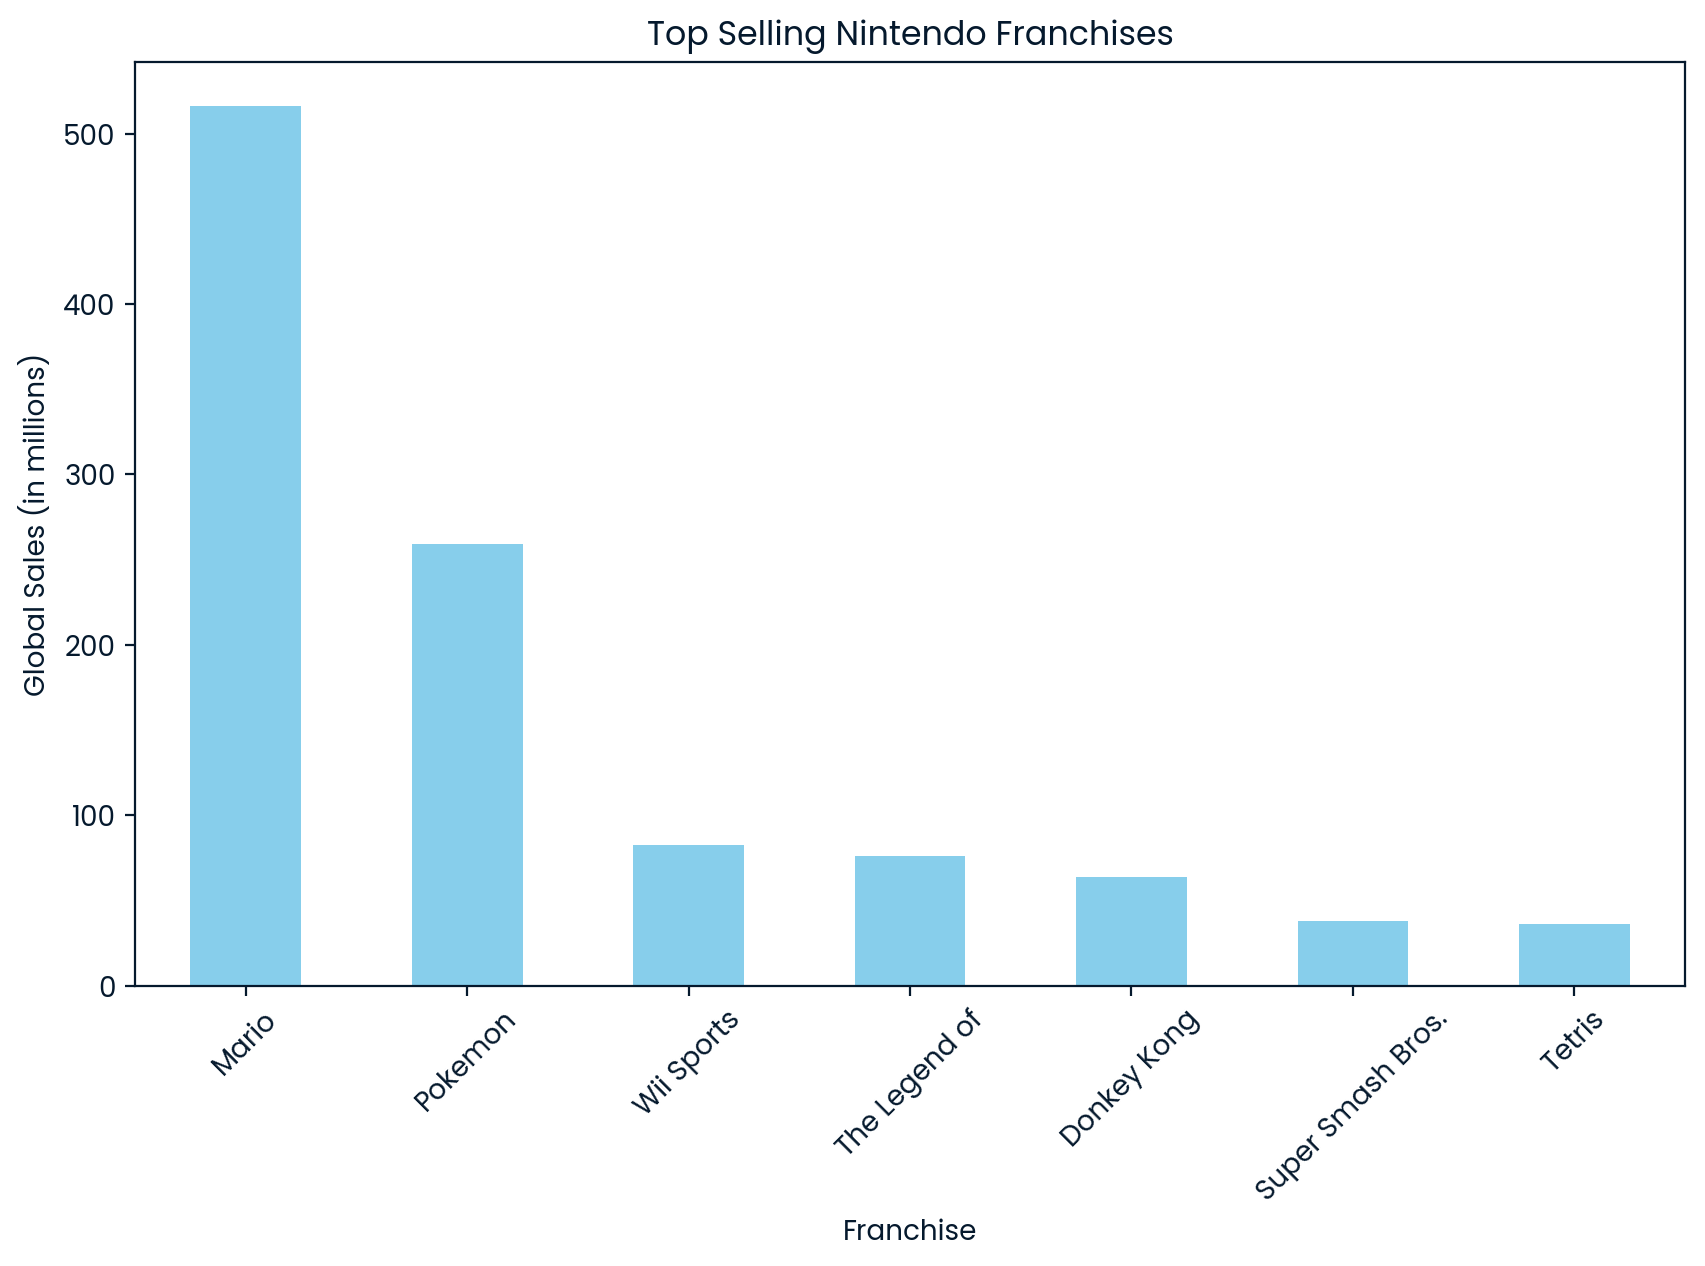

In [4]:
import matplotlib.pyplot as plt

# Summing up global sales for the top 5 Nintendo franchises and sorting them
top_franchises_sales = top_nintendo_franchises_df.groupby('Franchise')['Global_Sales'].sum().sort_values(ascending=False)

# Creating a bar plot for the top 5 selling Nintendo franchises
plt.figure(figsize=(10, 6))
top_franchises_sales.plot(kind='bar', color='skyblue')
plt.title('Top Selling Nintendo Franchises')
plt.xlabel('Franchise')
plt.ylabel('Global Sales (in millions)')
plt.xticks(rotation=45)
plt.show()

# Analysis of Question 1:
The graph below shows the consistent high sales of Nintendo compared to other Publishers. The question of why that is will be explored throughout this analysis. 

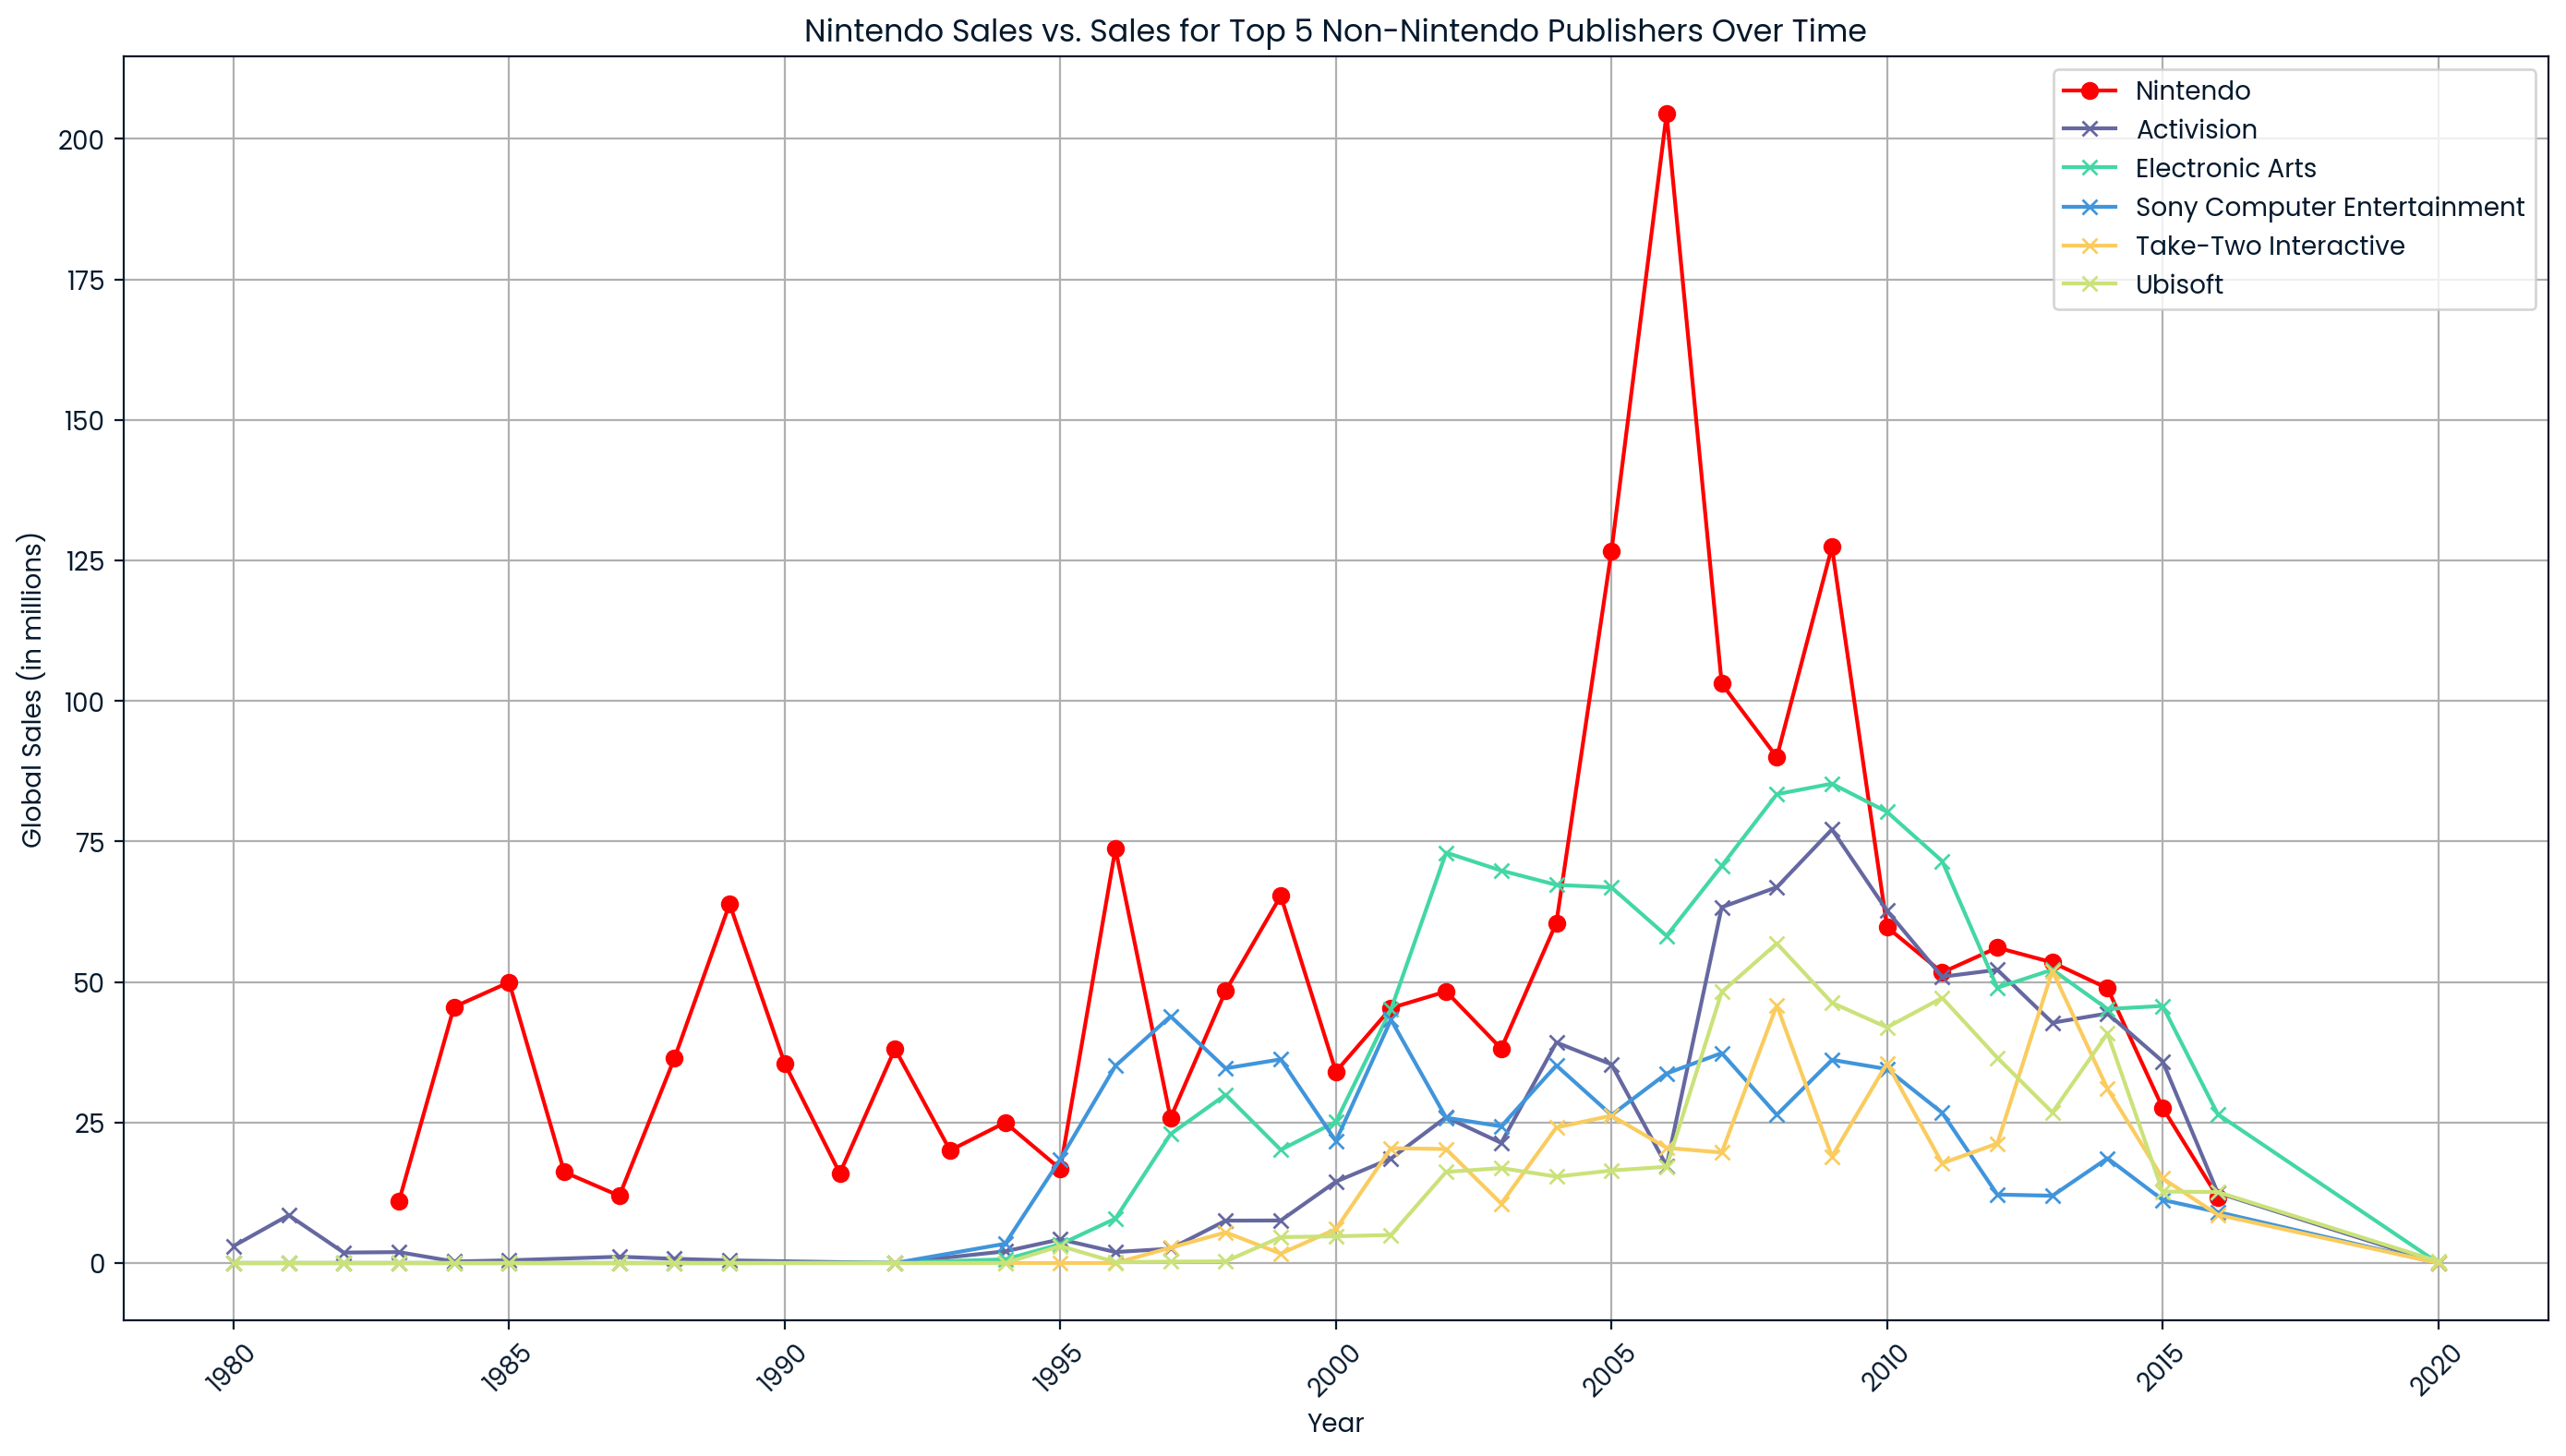

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
nintendo_yearly_sales = nintendo_df.groupby('Year_of_Release')['Global_Sales'].sum()

total_sales_non_nintendo_publishers = non_nintendo_df.groupby('Publisher')['Global_Sales'].sum()

top_5_non_nintendo_publishers = total_sales_non_nintendo_publishers.nlargest(5).index

top_5_non_nintendo_df = non_nintendo_df[non_nintendo_df['Publisher'].isin(top_5_non_nintendo_publishers)]


top_5_non_nintendo_yearly_sales = top_5_non_nintendo_df.groupby(['Year_of_Release', 'Publisher'])['Global_Sales'].sum().unstack().fillna(0)

plt.figure(figsize=(14, 8))

# Nintendo sales over time
plt.plot(nintendo_yearly_sales.index, nintendo_yearly_sales.values, label='Nintendo', color='red', marker='o')

# Sales for top 5 non-Nintendo publishers over time
for publisher in top_5_non_nintendo_yearly_sales.columns:
    plt.plot(top_5_non_nintendo_yearly_sales.index, top_5_non_nintendo_yearly_sales[publisher].values, label=publisher, marker='x')

plt.title('Nintendo Sales vs. Sales for Top 5 Non-Nintendo Publishers Over Time')
plt.xlabel('Year')
plt.ylabel('Global Sales (in millions)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd

nintendo_df['Is_Nintendo'] = 1
non_nintendo_df['Is_Nintendo'] = 0

combined_df = pd.concat([nintendo_df[['Global_Sales', 'Is_Nintendo']], non_nintendo_df[['Global_Sales', 'Is_Nintendo']]])

X = combined_df[['Global_Sales']]  # Feature matrix
y = combined_df['Is_Nintendo']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9542464114832536
Confusion Matrix:
[[3179   16]
 [ 137   12]]


### Summary:
The Decision Tree classifier was used to predict whether a game was published by Nintendo based on its global sales.
The model achieved an accuracy of 0.95 on the test set, indicating its effectiveness in distinguishing between Nintendo and non-Nintendo published games based on sales data alone.

In [7]:
data1 = pd.read_csv('vgsales.csv')
data1['Is_Nintendo'] = data1['Publisher'].apply(lambda x: 1 if x == 'Nintendo' else 0)

In [8]:
import statsmodels.api as sm

data_clean = data1.dropna()

X = data_clean[['Is_Nintendo','NA_Sales']]
y = data_clean['Global_Sales']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Global_Sales   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 3.709e+04
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        03:13:27   Log-Likelihood:                -5845.3
No. Observations:                6825   AIC:                         1.170e+04
Df Residuals:                    6822   BIC:                         1.172e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0002      0.008     -0.027      0.978      -0.015       0.015
Is_Nintendo     0.4678      0.035     13.444      0.000       0.400       0.536
NA_Sales        1.9211      0.007    264.349      0.000       1.907       1.935
==============================================================================
Omnibus:                     6792.391   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1229859.427
Skew:                           4.420   Prob(JB):                         0.00
Kurtosis:                      68.166   Cond. No.                         6.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Analysis of Question 6:
A hypotheses could be formed that the reasoning Nintendo has seen such success in its lifetime is its use of youthful rated games, meaning everyone is encouragaed to purchase and use their products, both pediatric and adult. The analysis below gathers a dataframe of the top 10% of the best selling 'E' rated games. The results show Nintendo as consuming nearly a quarter of that space, a space that encomapses all age levels.

In [9]:
# Filtering E rated games
E_rated_games = data1[data1['Rating'] == 'E']

top_10_percent_E_rated_games = E_rated_games.sort_values(by='Global_Sales', ascending=False).head(int(0.1 * len(E_rated_games)))
total_top_10_percent_E_rated_games = top_10_percent_E_rated_games.shape[0]
E_rated_nintendo_top_10_percent_games = top_10_percent_E_rated_games[top_10_percent_E_rated_games['Is_Nintendo'] == 1].shape[0]
percentage_E_rated_nintendo_top_10_percent = (E_rated_nintendo_top_10_percent_games / total_top_10_percent_E_rated_games) * 100
percentage_E_rated_nintendo_top_10_percent

23.809523809523807

In [10]:
sales_threshold = data1['Global_Sales'].quantile(0.9)

# Filter the dataframe to only include games in the top 10 percent of sales
top_10_percent_sales_games = data1[data1['Global_Sales'] >= sales_threshold]

In [11]:
top_5_franchises_sales = top_nintendo_franchises_df['Global_Sales'].sum()
total_nintendo_sales = nintendo_df['Global_Sales'].sum()
percentage_top_5_franchises_sales = (top_5_franchises_sales / total_nintendo_sales) * 100

percentage_top_5_franchises_sales

59.92251832223656

We see here that Nintendo's best selling franchises accumalte 60% of total game sales, a fact that should be analyzed to see the reasoning for the success behind nintendo franchsies.

In [12]:
import statsmodels.api as sm
top_5_franchises = top_nintendo_franchises_df['Franchise'].unique()
nintendo_df['Is_Top_5_Franchise'] = nintendo_df['Name'].apply(lambda x: any(franchise in x for franchise in top_5_franchises)).astype(int)
X = nintendo_df[['Is_Top_5_Franchise']]
y = nintendo_df['Global_Sales']
X = sm.add_constant(X)  
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Global_Sales   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     64.46
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           4.13e-15
Time:                        03:13:27   Log-Likelihood:                -2190.2
No. Observations:                 706   AIC:                             4384.
Df Residuals:                     704   BIC:                             4393.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.4594      0.243      6.005      0.000       0.982       1.937
Is_Top_5_Franchise     3.5443      0.441      8.029      0.000       2.678       4.411
==============================================================================
Omnibus:                      916.864   Durbin-Watson:                   0.234
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           148098.665
Skew:                           6.611   Prob(JB):                         0.00
Kurtosis:                      72.712   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model shows the prediction of global sales for nintendo games. It contains a predictor variable defining whether or not the game falls within the top 5 nintendo franchises. If it does, the model predicts there to be a 3.5 million dollar increase in sales for that game. 

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'Global_Sales' as the success metric for a franchise
# Filtering data for top 5 Nintendo franchises
top_5_franchises = top_nintendo_franchises_df['Franchise'].unique()[:5]
top_5_franchises_df = nintendo_df[nintendo_df['Name'].apply(lambda x: any(franchise in x for franchise in top_5_franchises))]

# Selecting relevant features and target variable
features = top_5_franchises_df[['Genre', 'Platform', 'NA_Sales']]
target = top_5_franchises_df['Global_Sales']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Creating a pipeline with OneHotEncoder for categorical features and LinearRegression model
categorical_features = ['Genre', 'Platform']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = make_column_transformer(
    (categorical_transformer, categorical_features),
    remainder='passthrough'
)

model = make_pipeline(preprocessor, LinearRegression())

# Fitting the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

Mean Squared Error: 3.08
R^2 Score: 0.92


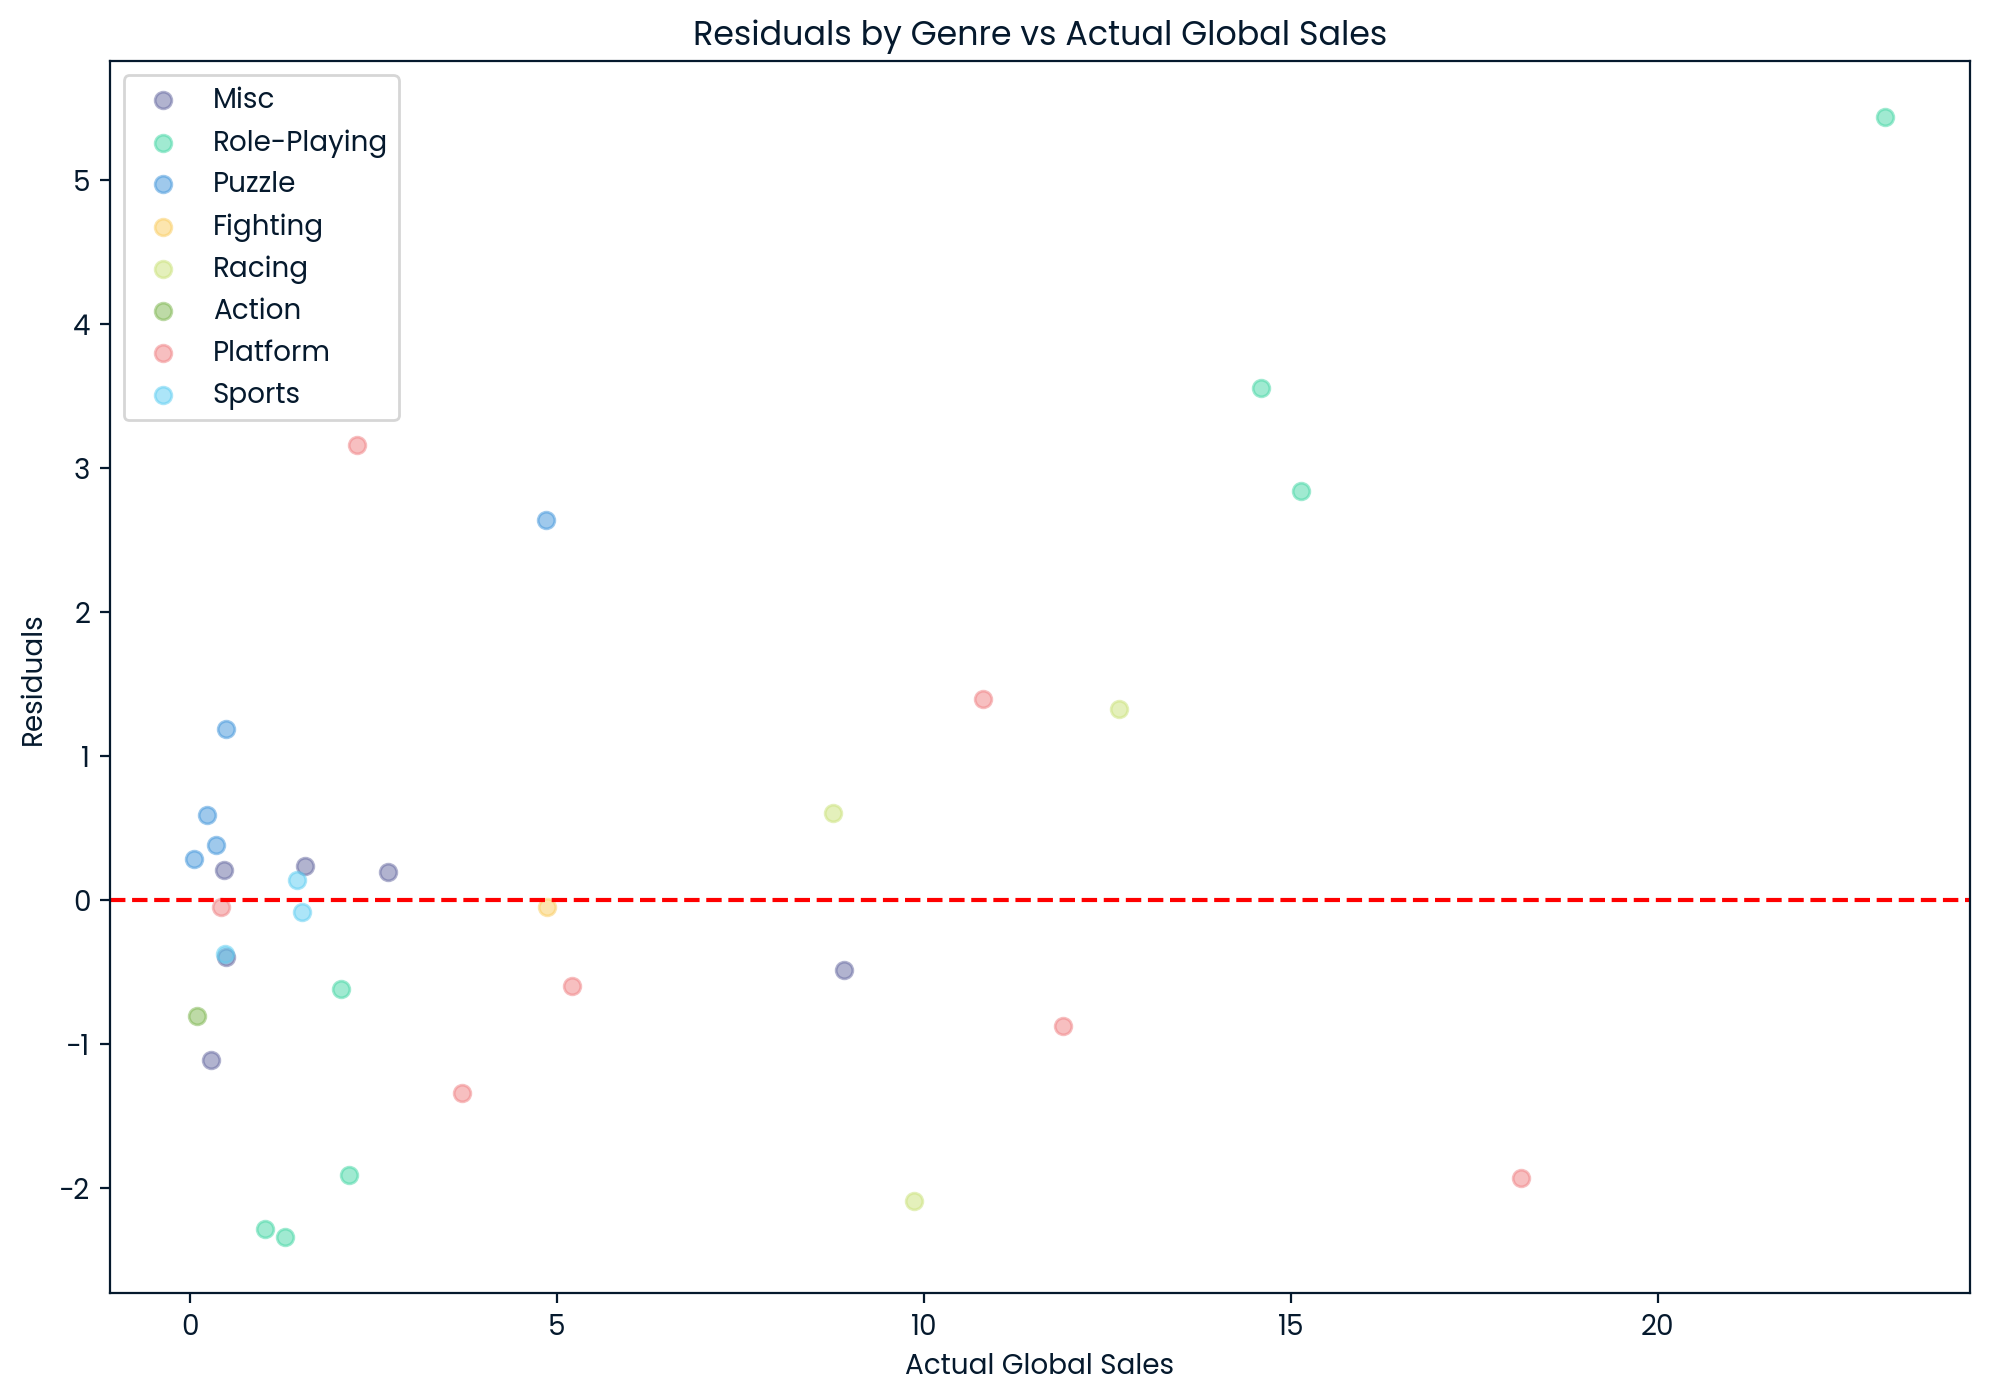

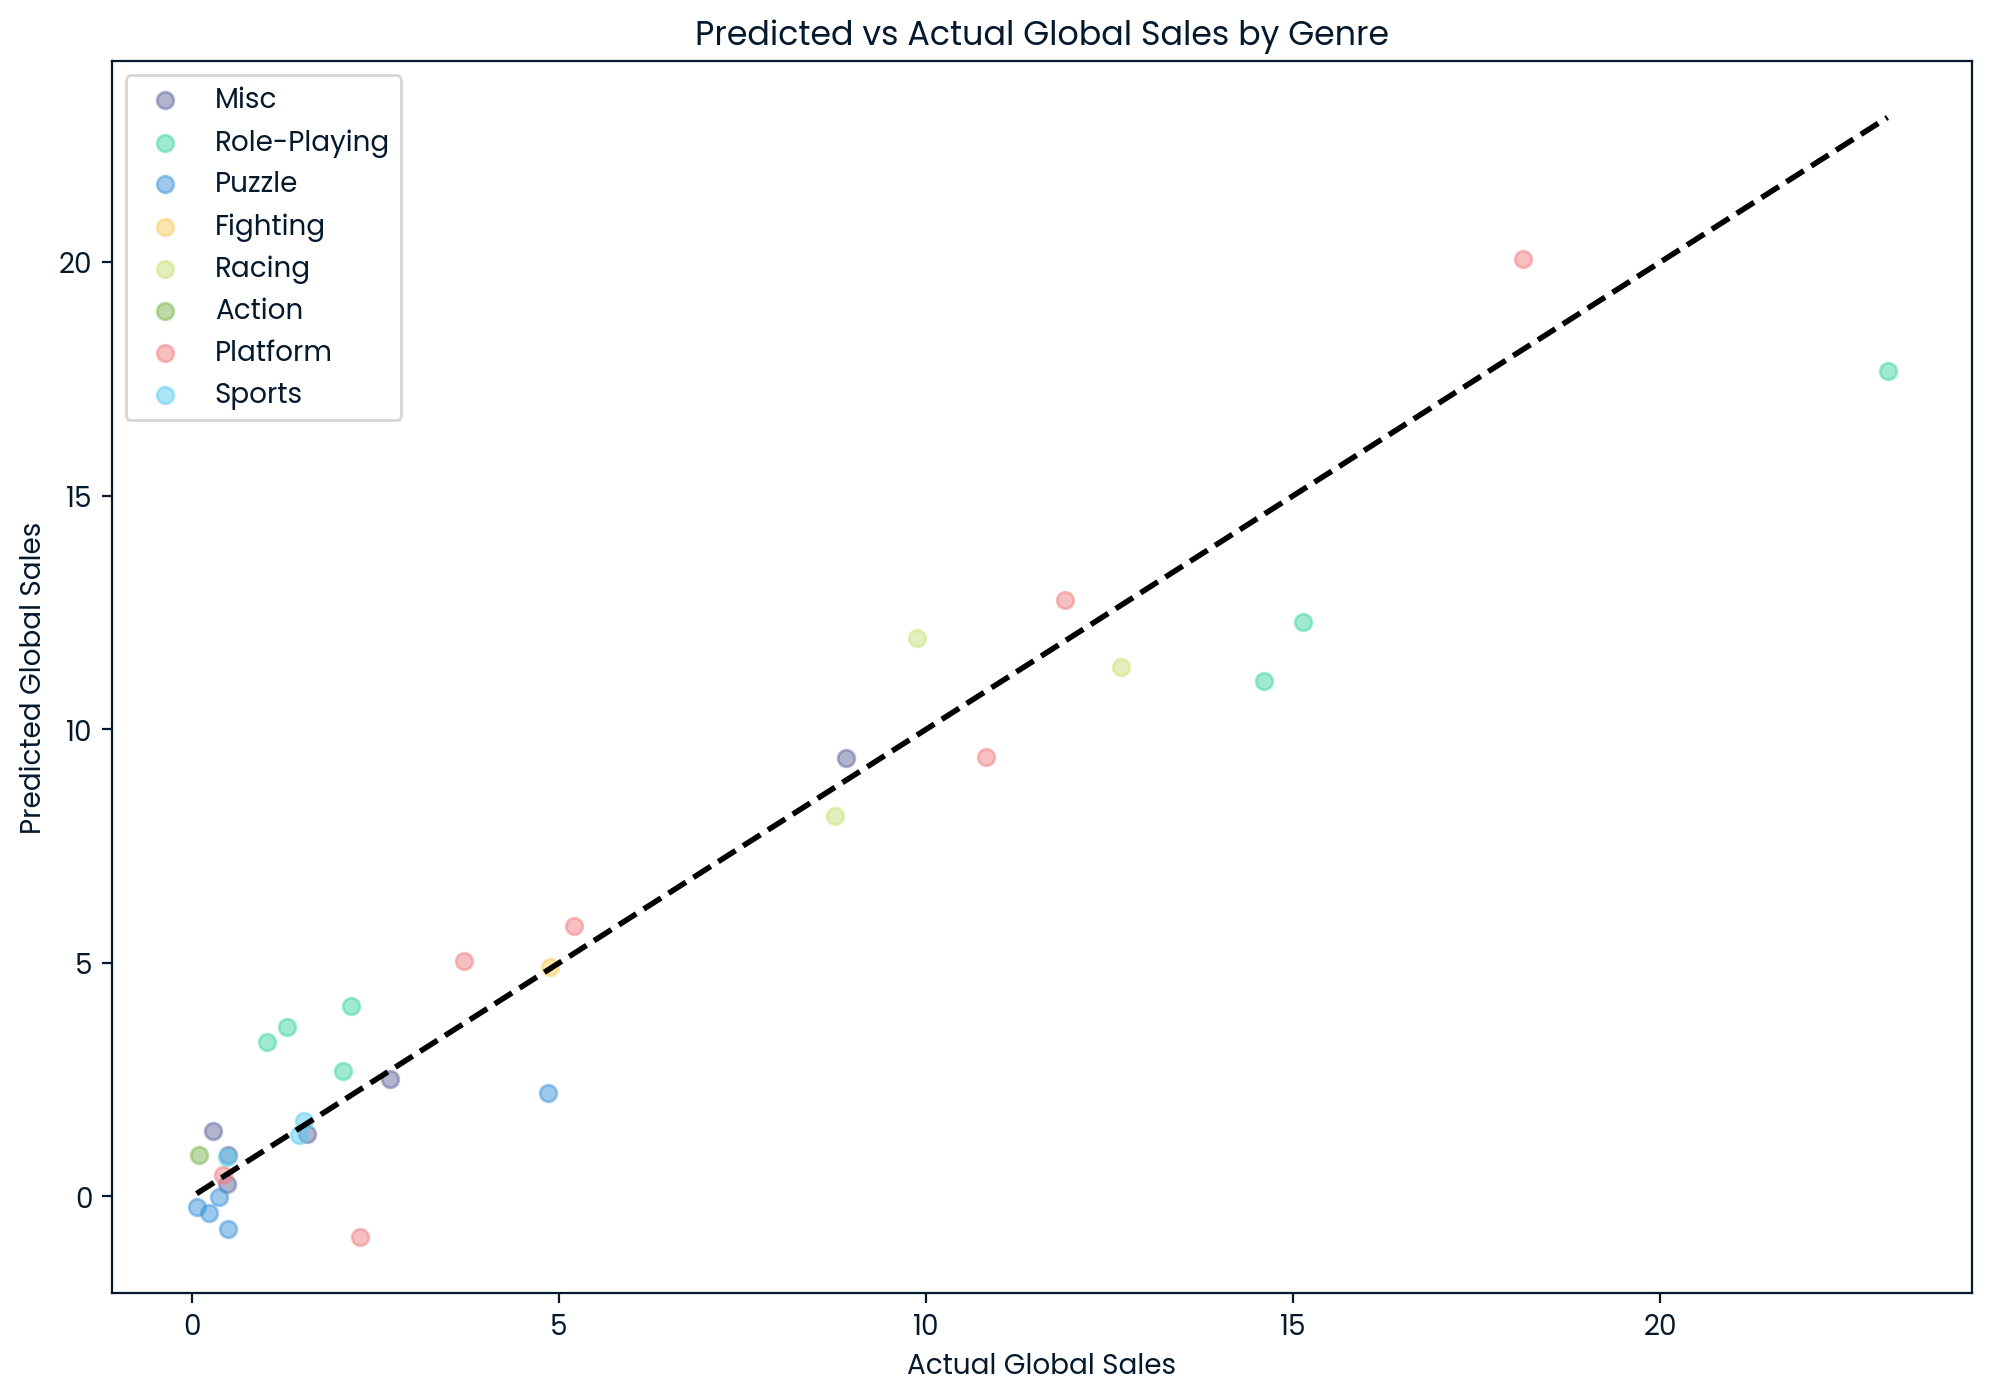

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_pred are defined in your environment as per the previous cells
# and that 'features' DataFrame contains the 'Genre' information for each game.

# Merging the residuals with the genres to analyze residuals by genre
residuals_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
residuals_df['Residuals'] = residuals_df['Actual'] - residuals_df['Predicted']
residuals_df = residuals_df.join(features['Genre'], how='left')  # Assuming the index matches

# Plotting residuals by genre
plt.figure(figsize=(12, 8))
for genre in residuals_df['Genre'].unique():
    subset = residuals_df[residuals_df['Genre'] == genre]
    plt.scatter(subset['Actual'], subset['Residuals'], label=genre, alpha=0.5)

plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Global Sales')
plt.ylabel('Residuals')
plt.title('Residuals by Genre vs Actual Global Sales')
plt.legend()
plt.show()

# Plotting predicted vs actual by genre
plt.figure(figsize=(12, 8))
for genre in residuals_df['Genre'].unique():
    subset = residuals_df[residuals_df['Genre'] == genre]
    plt.scatter(subset['Actual'], subset['Predicted'], label=genre, alpha=0.5)

plt.plot([residuals_df['Actual'].min(), residuals_df['Actual'].max()], 
         [residuals_df['Actual'].min(), residuals_df['Actual'].max()], 'k--', lw=2)
plt.xlabel('Actual Global Sales')
plt.ylabel('Predicted Global Sales')
plt.title('Predicted vs Actual Global Sales by Genre')
plt.legend()
plt.show()

This model uses predictors of genre, platform, and regional sales to predict global sales for the top Nintendo franchises. Linear regression was used to predict global sales. The graphs show how this model acurately predicts sales for seemingly every genre. To better distinguish how sales may differ between genres, a KNearest neaibors model may be more fitting to our data types. The model below shows how predictability for each genre may be more variable, but may ask have a high risk-reward feature. We see that role-playing games are often predicted as being high sellers, but that may not always be the case. Meanwhile, the adventure genre has lower variablilty, but predictably a lower sales ceiling.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
import numpy as np

# This script aims to predict the global sales of Nintendo games using a K-Nearest Neighbors regressor,
# with an additional step to remove outliers from the dataset before training the model.
# The features used for prediction include whether the game belongs to a top 5 franchise and its genre.
# The dataset is first cleaned to remove outliers, then split into training and testing sets.
# It undergoes preprocessing where numerical features are scaled and categorical features are one-hot encoded.
# Finally, the KNN model is trained, and its performance is evaluated using the root mean squared error (RMSE) metric.

# Removing outliers based on Global Sales
Q1 = nintendo_df['Global_Sales'].quantile(0.25)
Q3 = nintendo_df['Global_Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = nintendo_df[(nintendo_df['Global_Sales'] >= lower_bound) & (nintendo_df['Global_Sales'] <= upper_bound)]

X = filtered_df[['Is_Top_5_Franchise', 'Genre']]  # Features
y = filtered_df['Global_Sales']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Is_Top_5_Franchise']),
        ('cat', OneHotEncoder(), ['Genre'])
    ])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_transformed, y_train)
y_pred = knn.predict(X_test_transformed)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

rmse

1.0847962137640532

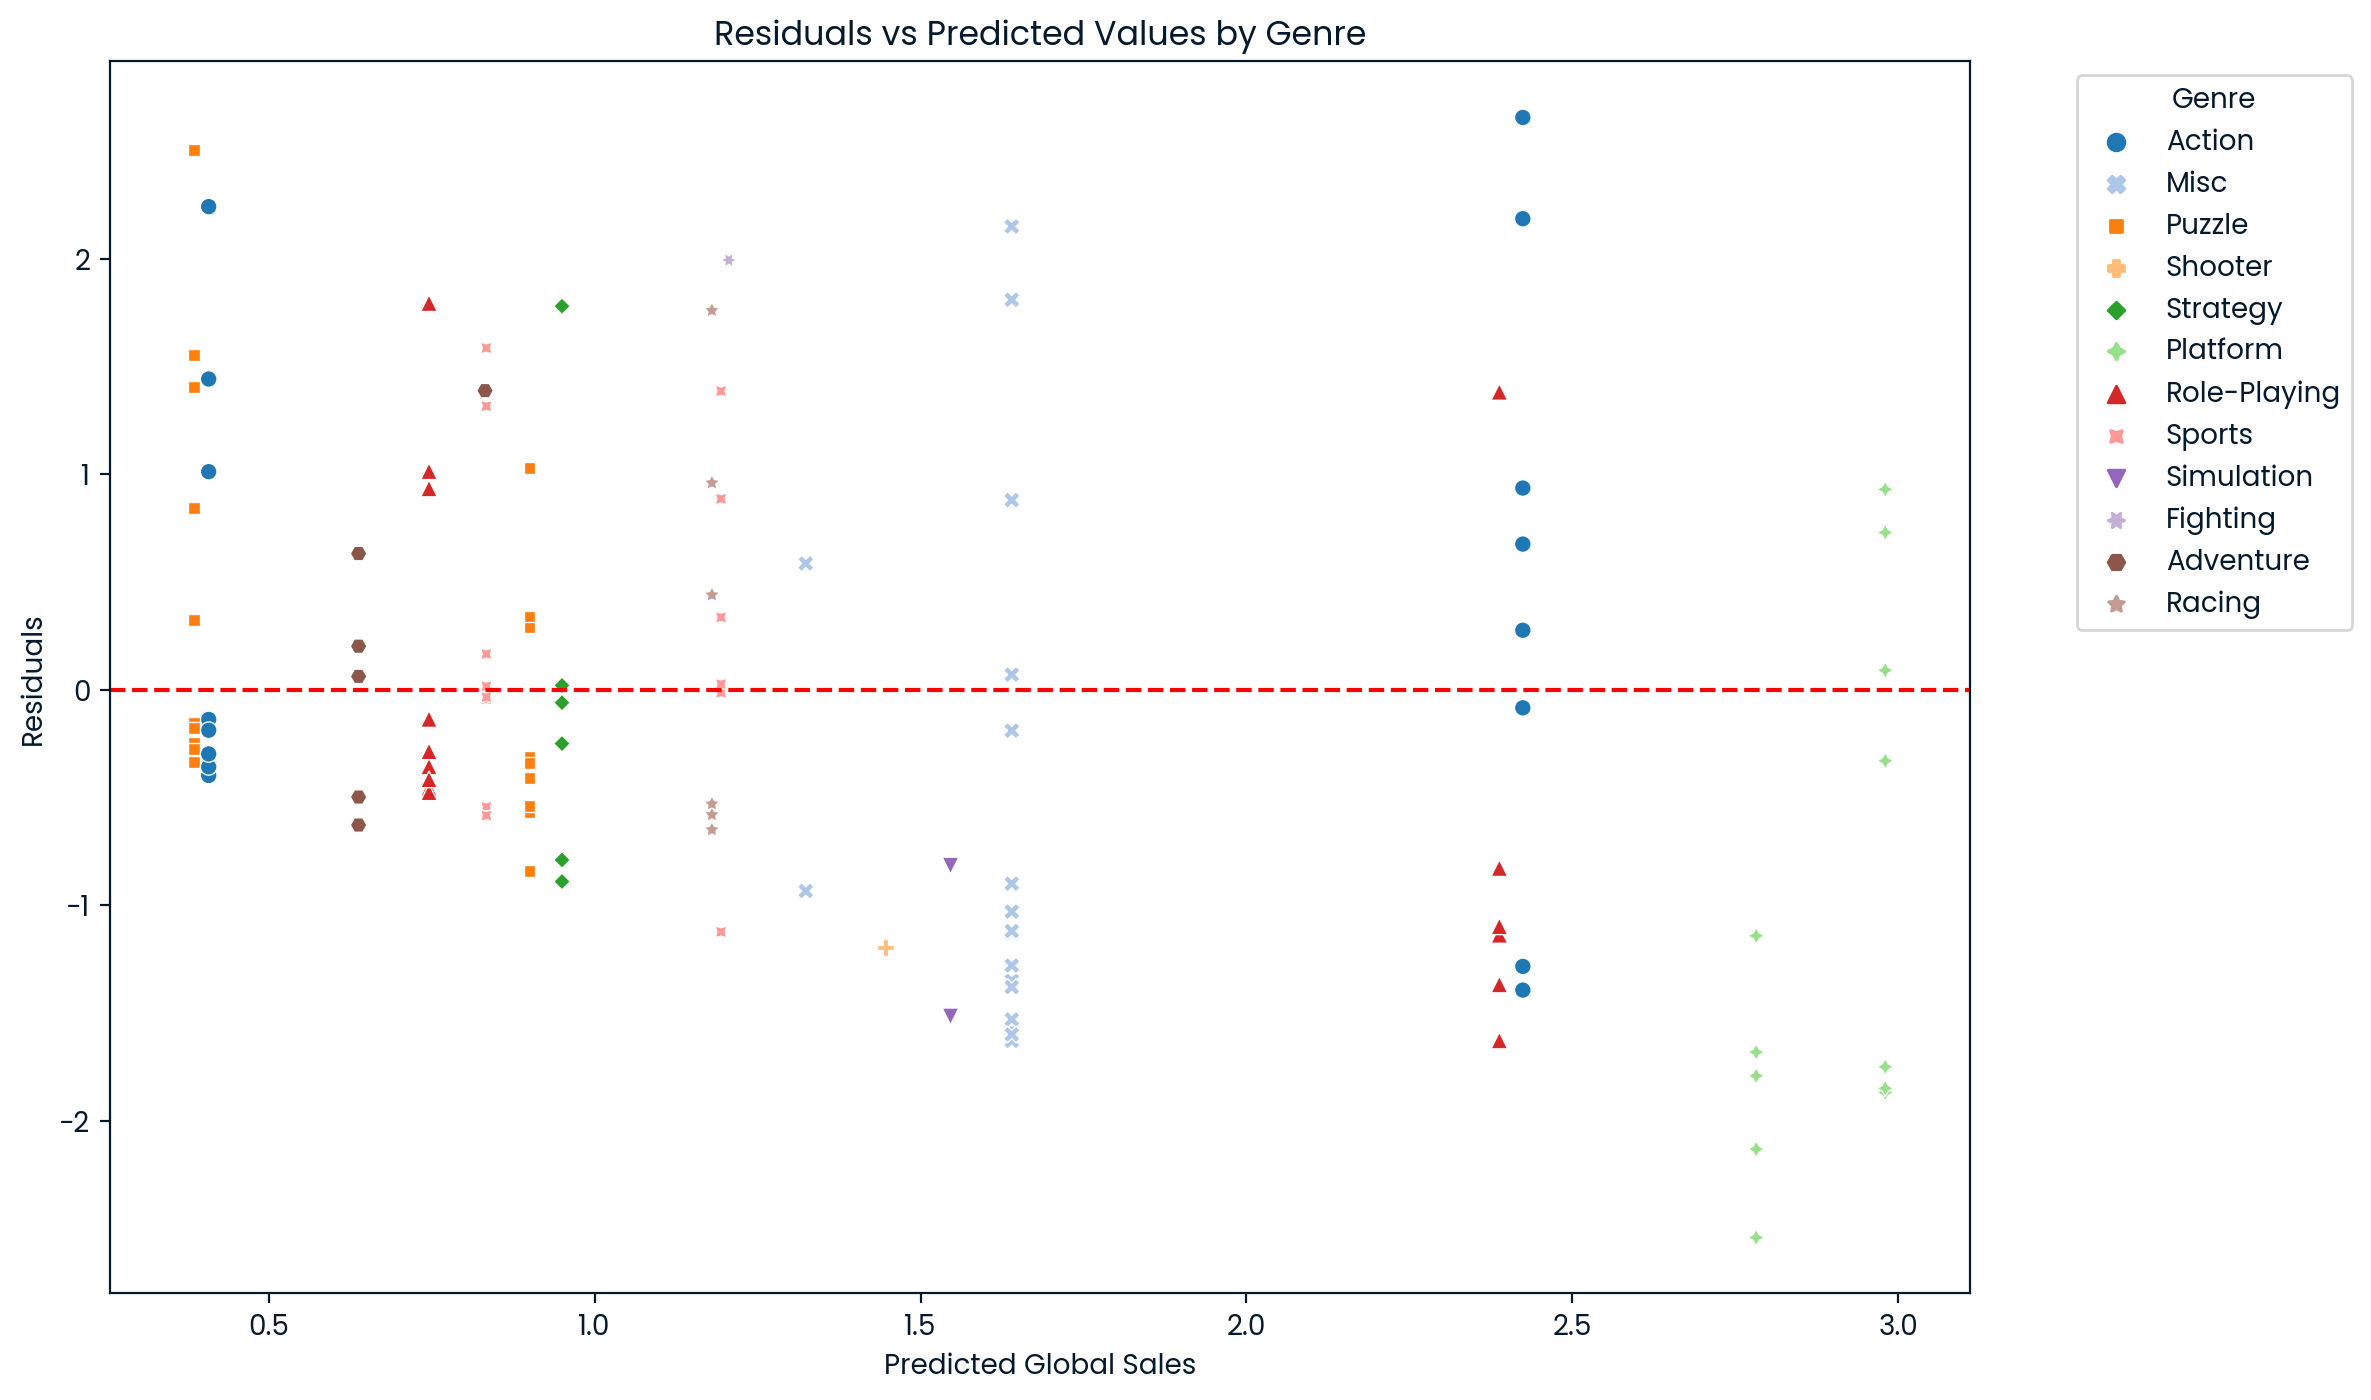

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test and y_pred are defined elsewhere in your notebook
# Calculate residuals
residuals = y_test - y_pred

# Create a DataFrame for visualization
residuals_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residuals': residuals, 'Genre': X_test['Genre']})

# Plotting the residuals with distinction based on Genre
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Predicted', y='Residuals', hue='Genre', data=residuals_df, palette='tab20', style='Genre')
plt.title('Residuals vs Predicted Values by Genre')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Global Sales')
plt.ylabel('Residuals')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()